### Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [113]:
import re
import os
import gc
import time
import pickle
import numpy as np
import pandas as pd
from pprint import pprint
from importlib import reload

In [ ]:
#!pip install --upgrade gensim 

In [285]:
#pyldavis
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
#, SnowballStemmer
#from nltk.stem.porter import *
#from nltk.corpus import stopwords

In [7]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

In [12]:
main_dir = '/tf/notebooks/'

In [105]:
data_path = main_dir+'final-project/data/sample/hein-daily'

In [106]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [107]:
reload(load_data)
start_time = time.time()
# remove p if want to run for the full speech file
descr = load_data.load_descr_data('/tf/notebooks/final-project/data/QA/full_descr.txt')
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1050088970
speaker Mr. MILLER of California
NonWhite 0.0
State CA
match exact
Chamber H
Party D
Age_lt_med 1.0
word_count 1173
char_count 6723
speakerid 105117740.0
Ethnicity W
Female 0.0
Congress 105
Age 53.0
check 1
Full Name MILLER, GEORGE
date 19971021

It took 16.7 seconds to create the dictionary


In [108]:
gender = load_data.create_target_labels(all_speech_ids, descr)[0]
len(gender)

283399

In [109]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 1622 ones and 1622 zeroes
Training speech list size: 3244
Training target list size: 3244
Validation split: 540 ones and 540 zeroes
Validation speech list size: 1080
Validation target list size: 1080
Test split: 542 ones and 542 zeroes
Test speech list size: 1084
Test target list size: 1084


In [13]:
outdata_path = main_dir + 'final-project/Classification/data'

In [110]:
with open(os.path.join(outdata_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(outdata_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(outdata_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(outdata_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(outdata_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(outdata_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(outdata_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(outdata_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(outdata_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [85]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)

In [18]:
with open(os.path.join(outdata_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)

In [111]:
del descr

In [114]:
gc.collect()

79

In [115]:
stop_words = stopwords.words('english')
stop_words.extend(['mr', 'senator', 'united', 'states', 'president', 'would', 'speaker', 'senate'])
lemma_stop_words = ['go', 'think', 'amend', 'say', 'time', 'committe', 'senat']

In [116]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(word):
    return stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v'))

def preprocess_speech(speech):
    processed_speech = []
    for word in gensim.utils.simple_preprocess(speech) :
        if word not in stop_words:
            word = lemmatize_stemming(word)
            if word not in lemma_stop_words:
                processed_speech.append(word)
            
    return processed_speech

In [117]:
train_processed = [preprocess_speech(speech) for speech in train]
val_processed = [preprocess_speech(speech) for speech in val]

In [118]:
bigram = gensim.models.Phrases(train_processed, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[train_processed], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(speeches):
    return [bigram_mod[speech] for speech in speeches]

def make_trigrams(speeches):
    return [trigram_mod[bigram_mod[speech]] for speech in speeches]

In [119]:
train_processed2 = make_trigrams(train_processed)
val_processed2 = make_trigrams(val_processed)
word_index = corpora.Dictionary(train_processed2)

In [120]:
bow_corpus = [word_index.doc2bow(speech) for speech in train_processed2]

In [121]:
check = sorted(bow_corpus[100], key=lambda x: -x[1])
for i in range(min(len(check),10)):
    print("Word {} (\"{}\") appears {} time(s).".format(check[i][0], 
                                                     word_index[check[i][0]], 
                                                     check[i][1]))

Word 1518 ("promot") appears 8 time(s).
Word 50 ("peopl") appears 7 time(s).
Word 69 ("thing") appears 6 time(s).
Word 1093 ("issu") appears 6 time(s).
Word 70 ("think") appears 5 time(s).
Word 33 ("hous") appears 4 time(s).
Word 488 ("save") appears 4 time(s).
Word 1516 ("bond") appears 4 time(s).
Word 30 ("go") appears 3 time(s).
Word 47 ("one") appears 3 time(s).


In [122]:
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=word_index,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       workers = 2)

In [123]:
pprint(lda_model.print_topics())

[(0,
  '0.010*"bill" + 0.010*"program" + 0.009*"provid" + 0.008*"feder" + '
  '0.008*"act" + 0.008*"legisl" + 0.007*"committe" + 0.006*"year" + '
  '0.006*"support" + 0.006*"fund"'),
 (1,
  '0.029*"hon" + 0.027*"crime" + 0.022*"crimin" + 0.017*"prison" + '
  '0.015*"victim" + 0.014*"nasa" + 0.013*"immigr" + 0.013*"coast_guard" + '
  '0.009*"space" + 0.009*"violent_crime"'),
 (2,
  '0.014*"lewi" + 0.006*"northern_ireland" + 0.004*"camera" + 0.004*"ireland" '
  '+ 0.003*"irish" + 0.002*"illeg_narcot" + 0.002*"prime_minist" + '
  '0.002*"laboratori" + 0.002*"cocain" + 0.001*"bobbi_sand"'),
 (3,
  '0.010*"year" + 0.008*"nation" + 0.007*"work" + 0.006*"school" + '
  '0.006*"serv" + 0.006*"one" + 0.006*"women" + 0.005*"servic" + '
  '0.005*"children" + 0.005*"american"'),
 (4,
  '0.018*"amend" + 0.011*"committe" + 0.010*"time" + 0.009*"senat" + '
  '0.009*"bill" + 0.009*"go" + 0.009*"think" + 0.008*"defens" + 0.008*"say" + '
  '0.008*"make"'),
 (5,
  '0.028*"sale" + 0.021*"israel" + 0.020*"s

In [124]:
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.334819809522262


In [126]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=train_processed2, 
                                     dictionary=word_index, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4182917320430035


In [131]:
def compute_coherence_values(dictionary, corpus, speeches, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model_list, coherence_values = [], []

    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           workers = 2)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, 
                                         texts=speeches, 
                                         dictionary=dictionary, 
                                         coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

In [132]:
model_list, coherence_values = compute_coherence_values(dictionary=word_index, 
                                                        corpus=bow_corpus, 
                                                        speeches=train_processed2, 
                                                        start=3, 
                                                        limit=21, 
                                                        step=3)

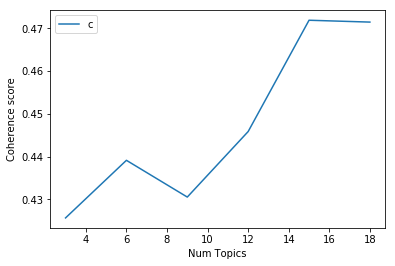

In [133]:
limit=21; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [134]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4256
Num Topics = 6  has Coherence Value of 0.4391
Num Topics = 9  has Coherence Value of 0.4305
Num Topics = 12  has Coherence Value of 0.4458
Num Topics = 15  has Coherence Value of 0.4719
Num Topics = 18  has Coherence Value of 0.4715


In [137]:
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.012*"bill" + 0.011*"program" + 0.010*"provid" + 0.010*"feder" + '
  '0.009*"committe" + 0.009*"act" + 0.008*"legisl" + 0.008*"fund" + '
  '0.007*"year" + 0.007*"state"'),
 (1,
  '0.047*"price" + 0.043*"agricultur" + 0.033*"farmer" + 0.033*"farm" + '
  '0.031*"product" + 0.030*"market" + 0.021*"produc" + 0.020*"acr" + '
  '0.018*"cost" + 0.015*"consum"'),
 (2,
  '0.037*"florida" + 0.022*"hunt" + 0.018*"lewi" + 0.015*"maritim" + '
  '0.008*"cargo" + 0.008*"northern_ireland" + 0.006*"new_mexico" + '
  '0.006*"trim" + 0.006*"provinc" + 0.006*"ship"'),
 (3,
  '0.009*"year" + 0.009*"servic" + 0.009*"armi" + 0.008*"offic" + '
  '0.008*"children" + 0.007*"area" + 0.007*"nation" + 0.006*"articl" + '
  '0.006*"system" + 0.006*"wilder"'),
 (4,
  '0.012*"defens" + 0.007*"militari" + 0.007*"product" + 0.007*"industri" + '
  '0.007*"year" + 0.006*"nation" + 0.005*"forc" + 0.005*"increas" + '
  '0.005*"percent" + 0.005*"must"'),
 (5,
  '0.115*"veteran" + 0.040*"va" + 0.018*"vietnam_veteran"

In [164]:
top_topics = optimal_model.top_topics(corpus=bow_corpus, 
                                      texts=train_processed2,
                                      coherence='c_v', 
                                      topn=10)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / 15
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(top_topics)

Average topic coherence: 0.4718.
[([(0.046588503, 'price'),
   (0.04255073, 'agricultur'),
   (0.03333348, 'farmer'),
   (0.033128496, 'farm'),
   (0.030589346, 'product'),
   (0.03046476, 'market'),
   (0.020846454, 'produc'),
   (0.01995777, 'acr'),
   (0.01841602, 'cost'),
   (0.014990734, 'consum')],
  0.7379000638232049),
 ([(0.024505733, 'budget'),
   (0.020087015, 'tax'),
   (0.019447058, 'year'),
   (0.014580862, 'program'),
   (0.014399712, 'cut'),
   (0.012777803, 'billion'),
   (0.012218925, 'percent'),
   (0.010090681, 'peopl'),
   (0.009312751, 'increas'),
   (0.009149192, 'spend')],
  0.6056845455807663),
 ([(0.030510489, 'school'),
   (0.022756936, 'educ'),
   (0.018617399, 'student'),
   (0.014396612, 'communiti'),
   (0.013531148, 'colleg'),
   (0.012437341, 'legal'),
   (0.010633267, 'servic'),
   (0.009912495, 'univers'),
   (0.00887009, 'citi'),
   (0.008743786, 'year')],
  0.5840895669923019),
 ([(0.01120966, 'cotton'),
   (0.006115908, 'restaur'),
   (0.0059693716

In [239]:
def get_topics_keywords_dict(ldamodel, num_topics):
    topic_dict = {}
    for i in range(num_topics):
        topic_dict[i] = [word[0] for word in ldamodel.show_topic(i)]
    return topic_dict

In [240]:
keywords_dict = get_topics_keywords_dict(optimal_model, 15)

In [242]:
def format_topics_sentences(ldamodel, corpus, speeches, ids, kw_dict):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        sorted_topics = sorted(row[0], key=lambda x: -x[1])
        topic_count = len(sorted_topics)
        
        topic1_num, topic1_contrib = sorted_topics[0]
        topic1_keywords = ','.join(kw_dict[topic1_num])
        
        if topic_count > 1:
            topic2_num, topic2_contrib = sorted_topics[1]
        else:
            topic2_num, topic2_contrib = -1, 0
        
        new_row = [topic_count, int(topic1_num), round(topic1_contrib,2), topic1_keywords, int(topic2_num), round(topic2_contrib,2)]
        sent_topics_df = sent_topics_df.append(pd.Series(new_row), ignore_index=True)

    sent_topics_df = pd.concat([sent_topics_df, pd.Series(ids)], axis=1)
    sent_topics_df.columns = ['Topic_Count', 'Prim_Topic', 'Prim_Topic_Contrib', 'Prim_Topic_Keywords', 'Sec_Topic', 'Sec_Topic_Contrib', 'Speech_id']
    
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, 
                                                  corpus=bow_corpus, 
                                                  speeches=train_processed2, 
                                                  ids=train_ids,
                                                  kw_dict=keywords_dict)
df_topic_sents_keywords.shape

(3244, 7)

In [243]:
df_topic_sents_keywords.head()

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id
0,2.0,9.0,0.75,"amend,say,go,think,time,committe,senat,vote,ge...",8.0,0.24,970228387
1,6.0,12.0,0.64,"nation,world,countri,peopl,american,soviet,gov...",8.0,0.10,970020112
2,4.0,9.0,0.63,"amend,say,go,think,time,committe,senat,vote,ge...",0.0,0.21,970222405
3,3.0,9.0,0.75,"amend,say,go,think,time,committe,senat,vote,ge...",8.0,0.17,970192743
4,5.0,4.0,0.51,"defens,militari,product,industri,year,nation,f...",0.0,0.23,970005171


In [215]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Prim_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Prim_Topic_Contrib'], ascending=[0]).head(1)], 
                                      axis=0)

sent_topics_sorteddf.reset_index(drop=True, inplace=True)
sent_topics_sorteddf

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id
0,1.0,0.0,0.99,"bill, program, provid, feder, committe, act, l...",-1.0,0.00,970113346
1,1.0,1.0,0.92,"price, agricultur, farmer, farm, product, mark...",-1.0,0.00,970201931
2,2.0,3.0,0.85,"year, servic, armi, offic, children, area, nat...",7.0,0.08,970238540
3,1.0,4.0,0.97,"defens, militari, product, industri, year, nat...",-1.0,0.00,970019917
4,4.0,6.0,0.85,"senat, committe, offic, drug, bank, hear, inve...",0.0,0.09,970196014
5,1.0,8.0,0.98,"budget, tax, year, program, cut, billion, perc...",-1.0,0.00,970164066
6,1.0,9.0,0.98,"amend, say, go, think, time, committe, senat, ...",-1.0,0.00,970201152
7,8.0,10.0,0.29,"israel, sale, saudi, middl_east, saudi_arabia,...",12.0,0.23,970033271
8,6.0,11.0,0.63,"school, educ, student, communiti, colleg, lega...",14.0,0.21,970096524
9,1.0,12.0,1.00,"nation, world, countri, peopl, american, sovie...",-1.0,0.00,970088258


In [216]:
for i in range(sent_topics_sorteddf.shape[0]):
    print("Topic number: ", sent_topics_sorteddf.Prim_Topic[i])
    print("Topic contribution: {:.2f}".format(sent_topics_sorteddf.Prim_Topic_Contrib[i]))
    print("Keywords: \n", sent_topics_sorteddf.Prim_Topic_Keywords[i])
    print("Speech: \n", train[train_ids.index(sent_topics_sorteddf.Speech_id[i])])
    print("-"*50)

Topic number:  0.0
Topic contribution: 0.99
Keywords: 
 bill, program, provid, feder, committe, act, legisl, fund, year, state
Speech: 
 Mr. President. S. 1211. now before the Senate reauthorizes the Toxic Substances Control Act. As it was amended by the House of Representatives. it authorizes $63.5 million for each of the fiscal years 1982 and 1983. The bill makes no substantive amendment to the act. This is the second time that the Senate has acted on S. 1211. The bill was passed by the Senate on June 2. 1981. Then. it authorized $59.64 6 for fiscal year 1982 only. The bill was amended by the House of Representatives and returned to the Senate on September 29. 1981 with the longer and higher authorization. President Reagans request for authorization to the Environmental Protection Agency for administration of the Toxic Substances Control Act was $60.146.000. That amount represe~nts a decrease of $8.3 million from the 1981 resource level. The proposed authorization level would support

In [244]:
df_topic_sents_keywords.head()

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id
0,2.0,9.0,0.75,"amend,say,go,think,time,committe,senat,vote,ge...",8.0,0.24,970228387
1,6.0,12.0,0.64,"nation,world,countri,peopl,american,soviet,gov...",8.0,0.10,970020112
2,4.0,9.0,0.63,"amend,say,go,think,time,committe,senat,vote,ge...",0.0,0.21,970222405
3,3.0,9.0,0.75,"amend,say,go,think,time,committe,senat,vote,ge...",8.0,0.17,970192743
4,5.0,4.0,0.51,"defens,militari,product,industri,year,nation,f...",0.0,0.23,970005171


In [279]:
topics_df = pd.DataFrame(index=range(15))
# Number of Documents for Each Topic
prim_topic_counts = df_topic_sents_keywords['Prim_Topic'].value_counts().sort_index()
sec_topic_counts = df_topic_sents_keywords['Sec_Topic'].value_counts().sort_index()
# Percentage of Documents for Each Topic
prim_topic_share = round(prim_topic_counts/len(train), 2)
prim_topic_share.name = 'Prim_Topic_Contr'
sec_topic_share = round(sec_topic_counts/len(train), 2)
sec_topic_share.name = 'Sec_Topic_Contr'

In [280]:
topics_df= topics_df.join(prim_topic_counts)\
                    .join(prim_topic_share)\
                    .join(sec_topic_counts)\
                    .join(sec_topic_share)\
                    .join(pd.DataFrame.from_dict(keywords_dict, orient='index'))
topics_df.reset_index(inplace=True)
topics_df.columns = ['Topic_Num', "Prim_Cnt", "Prim_Share", "Sec_Cnt", "Sec_Share"] + ['kw'+str(i) for i in range(10)]
topics_df.Prim_Cnt.sum(), topics_df.Prim_Share.sum(), topics_df.Sec_Cnt.sum(), topics_df.Sec_Share.sum()

(3244.0, 1.0, 3104, 0.96)

In [281]:
topics_df.sort_values(by='Prim_Cnt', ascending=False)

,Topic_Num,Prim_Cnt,Prim_Share,Sec_Cnt,Sec_Share,kw0,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9
9,9,1056.0,0.33,576,0.18,amend,say,go,think,time,committe,senat,vote,gentleman,bill
0,0,707.0,0.22,571,0.18,bill,program,provid,feder,committe,act,legisl,fund,year,state
8,8,403.0,0.12,456,0.14,budget,tax,year,program,cut,billion,percent,peopl,increas,spend
12,12,358.0,0.11,266,0.08,nation,world,countri,peopl,american,soviet,govern,soviet_union,intern,must
14,14,316.0,0.10,277,0.09,work,year,great,one,women,serv,nation,mani,american,know
4,4,276.0,0.09,489,0.15,defens,militari,product,industri,year,nation,forc,increas,percent,must
3,3,43.0,0.01,125,0.04,year,servic,armi,offic,children,area,nation,articl,system,wilder
6,6,40.0,0.01,94,0.03,senat,committe,offic,drug,bank,hear,investig,land,indian,ask_unanim_consent
11,11,30.0,0.01,139,0.04,school,educ,student,communiti,colleg,legal,servic,univers,citi,year
1,1,14.0,0.00,65,0.02,price,agricultur,farmer,farm,product,market,produc,acr,cost,consum
